E-commerce Return Rate Reduction Analysis using Superstore Data

Steps:
1. Load Data: Load Orders and Returns CSV files.
2. Merge & Clean Data: Merge datasets, create 'IsReturned' flag, handle data types.
3. Exploratory Data Analysis (EDA): Analyze return rates by Category, Sub-Category,
   Region, and Manufacturer.
4. Feature Engineering & Preprocessing: Prepare data for modeling.
5. Model Training: Train a Logistic Regression model to predict order returns.
6. Model Evaluation: Evaluate the model performance.
7. Identify High-Risk Orders: Generate a CSV of orders with high predicted
   return probability.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings

In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Load Data ---
print("1. Loading data...")
orders_df = pd.read_csv(r"C:\Users\shant\OneDrive\Desktop\Intern\Project\sample_-_superstore.csv", encoding='latin1')
returns_df = pd.read_csv(r"C:\Users\shant\OneDrive\Desktop\Intern\Project\sample_-_superstore returns.csv", encoding='latin1')
print("Data Loaded")

1. Loading data...
Data Loaded


In [3]:
print(orders_df.columns)

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')


In [4]:
print(returns_df.columns)

Index(['Returned', 'Order ID'], dtype='object')



Initial Orders Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-n

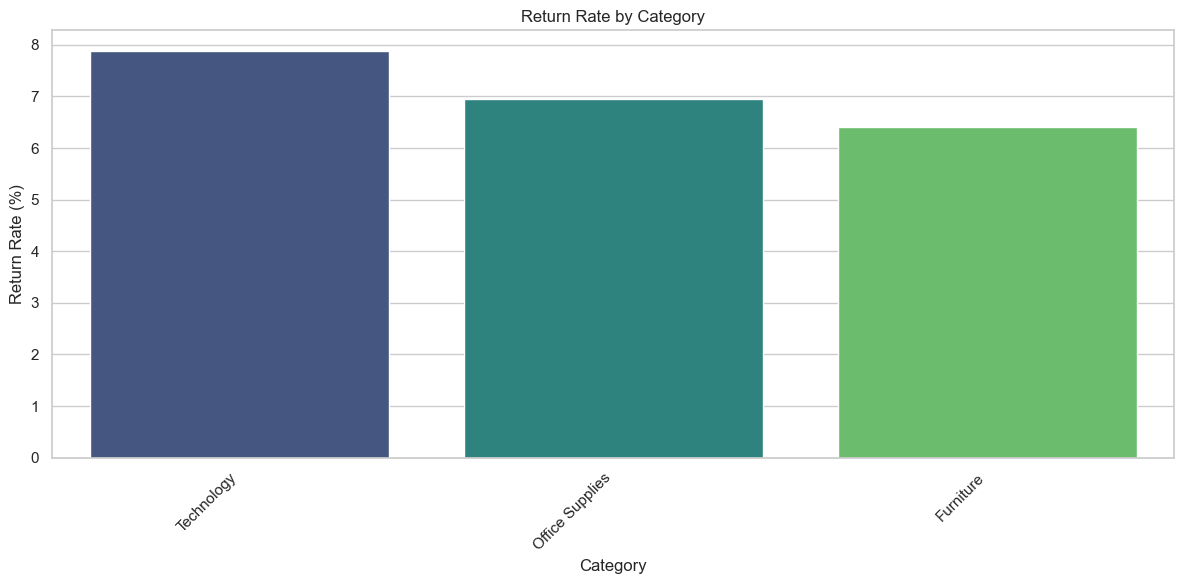


Return Rate by Category (Top 3 shown):
Category
Technology         7.884615
Office Supplies    6.942753
Furniture          6.412478
Name: IsReturned, dtype: float64


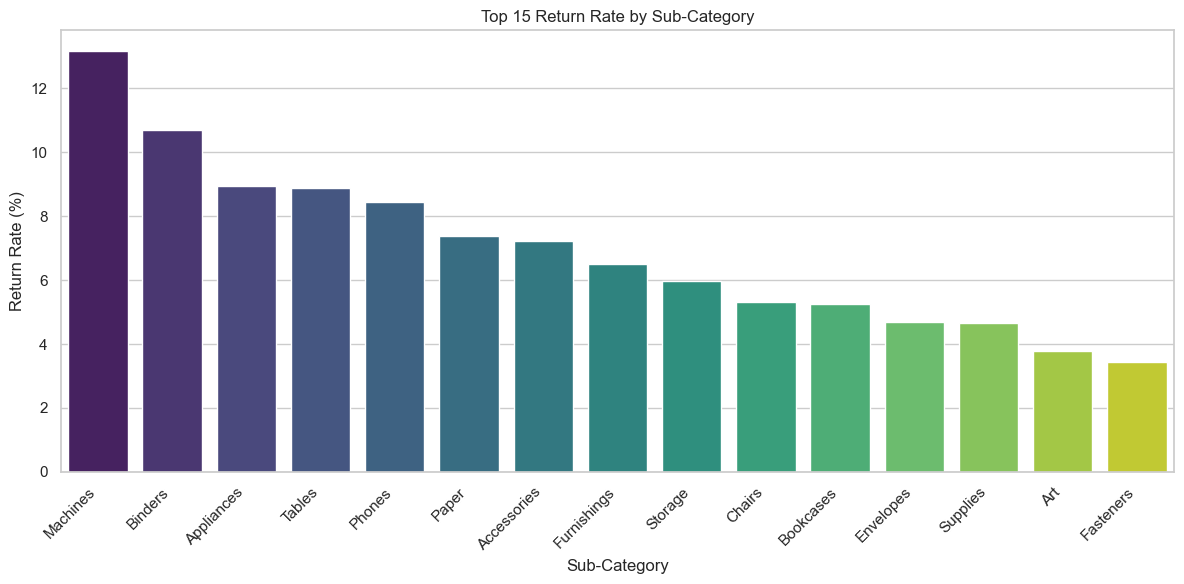


Return Rate by Sub-Category (Top 15 shown):
Sub-Category
Machines       13.157895
Binders        10.688836
Appliances      8.943089
Tables          8.888889
Phones          8.438819
Paper           7.368421
Accessories     7.239819
Furnishings     6.513410
Storage         5.982906
Chairs          5.325444
Bookcases       5.263158
Envelopes       4.687500
Supplies        4.651163
Art             3.773585
Fasteners       3.448276
Name: IsReturned, dtype: float64


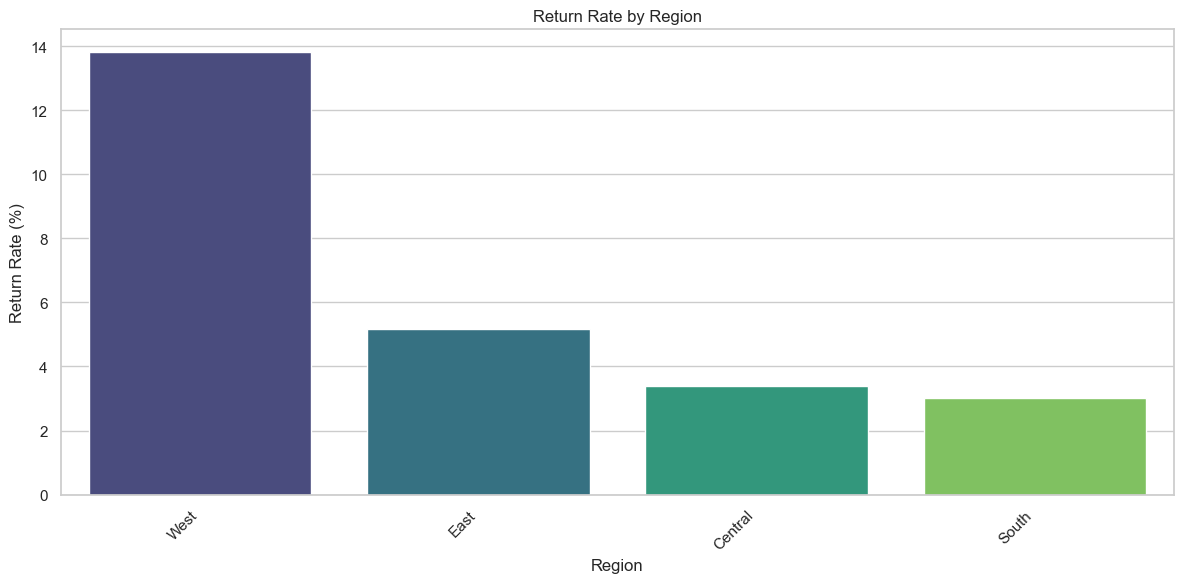


Return Rate by Region (Top 4 shown):
Region
West       13.838748
East        5.157233
Central     3.389831
South       3.017241
Name: IsReturned, dtype: float64


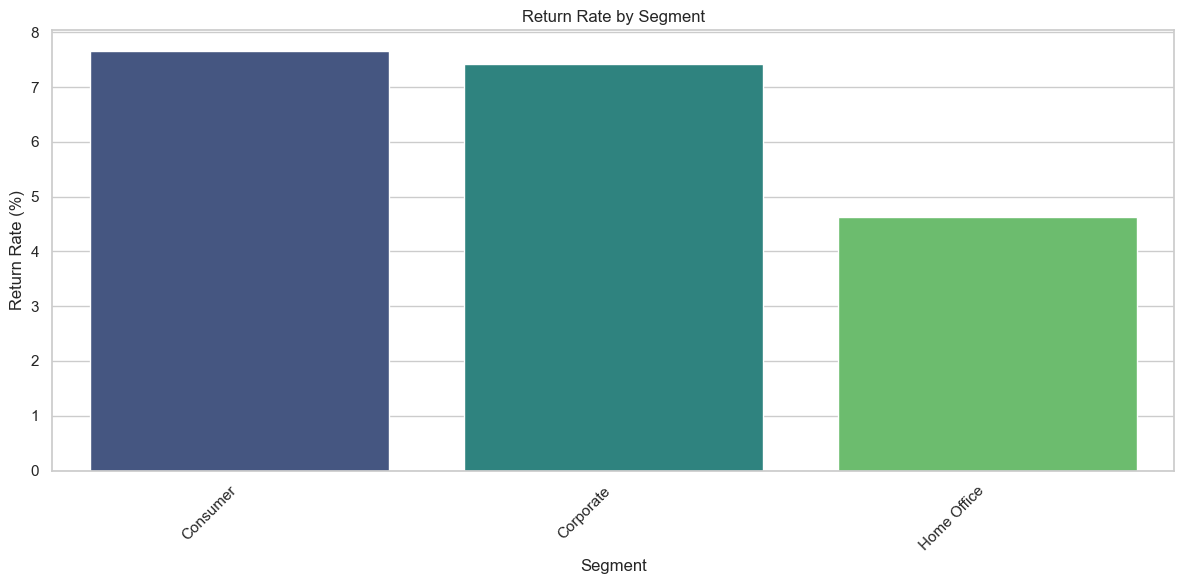


Return Rate by Segment (Top 3 shown):
Segment
Consumer       7.654146
Corporate      7.416564
Home Office    4.624277
Name: IsReturned, dtype: float64


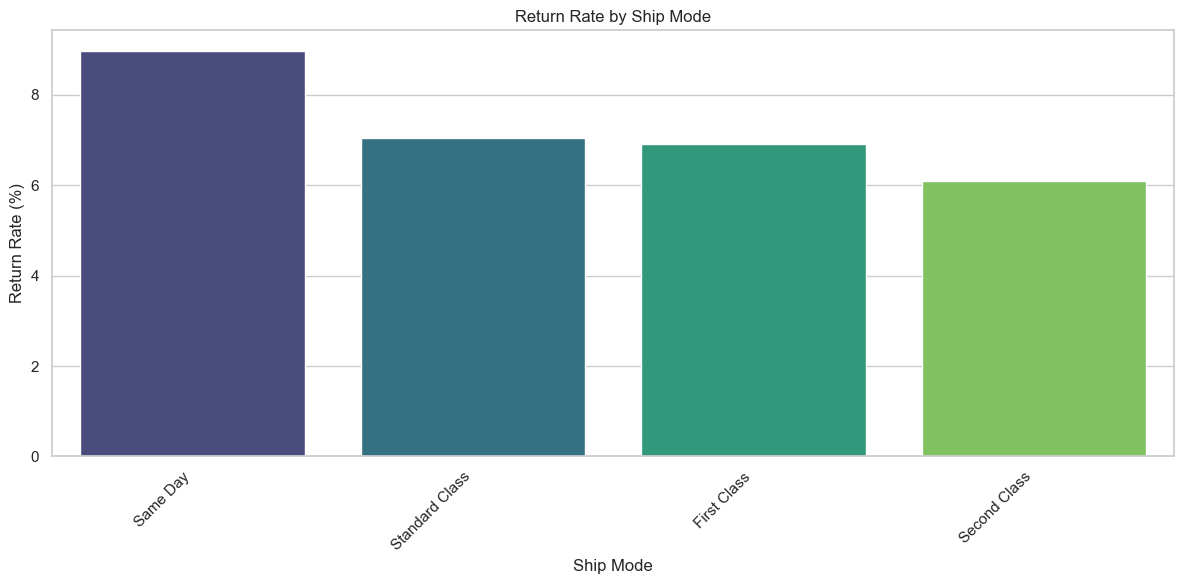


Return Rate by Ship Mode (Top 4 shown):
Ship Mode
Same Day          8.979592
Standard Class    7.052186
First Class       6.915888
Second Class      6.099815
Name: IsReturned, dtype: float64

'Manufacturer' column not found, skipping supplier-like analysis.

EDA Complete.


In [5]:
# Display initial data info
print("\nInitial Orders Data Info:")
orders_df.info()
print(f"\nOrders Shape: {orders_df.shape}")
print("\nInitial Returns Data Info:")
returns_df.info()
print(f"Returns Shape: {returns_df.shape}")


# --- 2. Merge & Clean Data ---
print("\n2. Merging and Cleaning Data...")

# Check for key columns
if 'Order ID' not in orders_df.columns or 'Order ID' not in returns_df.columns:
    print("Error: 'Order ID' column not found in one or both datasets. Cannot merge.")
    exit()


returned_order_ids = returns_df['Order ID'].unique()
orders_df['IsReturned'] = orders_df['Order ID'].apply(lambda x: 1 if x in returned_order_ids else 0)

# Convert date columns to datetime objects
try:
    orders_df['Order Date'] = pd.to_datetime(orders_df['Order Date'], errors='coerce')
    orders_df['Ship Date'] = pd.to_datetime(orders_df['Ship Date'], errors='coerce')
except Exception as e:
    print(f"Error converting date columns: {e}")
    
print("\nMissing values before cleaning:")
print(orders_df.isnull().sum())

orders_df.drop_duplicates(inplace=True)

orders_df['DaysToShip'] = (orders_df['Ship Date'] - orders_df['Order Date']).dt.days

# Handle potential negative DaysToShip (data errors)
orders_df = orders_df[orders_df['DaysToShip'] >= 0]

print("\nData Merged and Cleaned.")
print(f"Shape after cleaning: {orders_df.shape}")
print("\nValue counts for IsReturned:")
print(orders_df['IsReturned'].value_counts(normalize=True))

# --- 3. Exploratory Data Analysis (EDA) ---
print("\n3. Performing Exploratory Data Analysis (EDA)...")

# plot style
sns.set(style="whitegrid")

# Overall Return Rate
overall_return_rate = orders_df['IsReturned'].mean()
print(f"\nOverall Order Return Rate: {overall_return_rate:.2%}")

# --- Function for plotting return rates ---
def plot_return_rate(df, column_name, top_n=15):
    """Calculates and plots return rates for a given categorical column."""
    # Calculate return rate per group
    return_rates = df.groupby(column_name)['IsReturned'].mean().sort_values(ascending=False) * 100

    
    if len(return_rates) > top_n:
        return_rates = return_rates.head(top_n)
        plot_title = f'Top {top_n} Return Rate by {column_name}'
    else:
        plot_title = f'Return Rate by {column_name}'

    plt.figure(figsize=(12, 6))
    sns.barplot(x=return_rates.index, y=return_rates.values, palette="viridis")
    plt.title(plot_title)
    plt.ylabel('Return Rate (%)')
    plt.xlabel(column_name)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(f"\nReturn Rate by {column_name} (Top {min(top_n, len(return_rates))} shown):")
    print(return_rates)


# Analyze return rates by different dimensions
plot_return_rate(orders_df, 'Category')
plot_return_rate(orders_df, 'Sub-Category')
plot_return_rate(orders_df, 'Region')
plot_return_rate(orders_df, 'Segment')
plot_return_rate(orders_df, 'Ship Mode')

# Use Manufacturer as proxy for Supplier
if 'Manufacturer' in orders_df.columns:
     plot_return_rate(orders_df, 'Manufacturer')
else:
    print("\n'Manufacturer' column not found, skipping supplier-like analysis.")

print("\nEDA Complete.")







In [7]:
# --- 4. Feature Engineering & Preprocessing ---
print("\n4. Preparing data for modeling...")


features = ['Segment', 'Ship Mode', 'Region', 'Category', 'Sub-Category',
            'Sales', 'Quantity', 'Discount', 'Profit', 'DaysToShip']
if 'Manufacturer' in orders_df.columns:
    features.append('Manufacturer')

target = 'IsReturned'

X = orders_df[features]
y = orders_df[target]

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns 

print(f"\nCategorical features: {list(categorical_features)}")
print(f"Numerical features: {list(numerical_features)}")


numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False) 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' 
)

print("\nPreprocessing pipeline created.")


4. Preparing data for modeling...

Categorical features: ['Segment', 'Ship Mode', 'Region', 'Category', 'Sub-Category']
Numerical features: ['Sales', 'Quantity', 'Discount', 'Profit', 'DaysToShip']

Preprocessing pipeline created.


In [8]:
# --- 5. Model Training ---
print("\n5. Training Logistic Regression Model...")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


model = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LogisticRegression(solver='liblinear',
                                                         class_weight='balanced', 
                                                         random_state=42))])

# Train the model
model.fit(X_train, y_train)

print("\nModel training complete.")


5. Training Logistic Regression Model...
Training set shape: (1917, 10)
Test set shape: (822, 10)

Model training complete.



6. Evaluating Model Performance...

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79       764
           1       0.12      0.60      0.20        58

    accuracy                           0.67       822
   macro avg       0.54      0.64      0.50       822
weighted avg       0.90      0.67      0.75       822


Confusion Matrix:


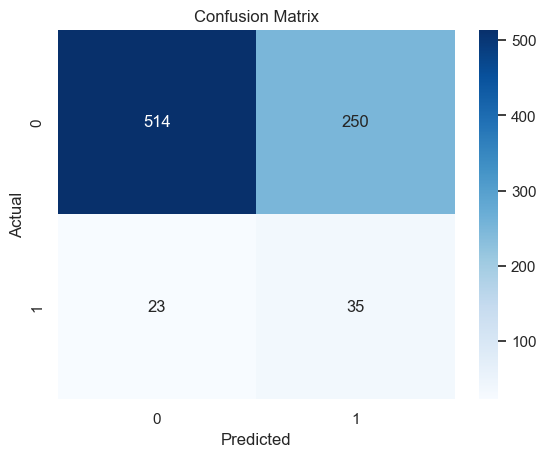


ROC AUC Score: 0.6639


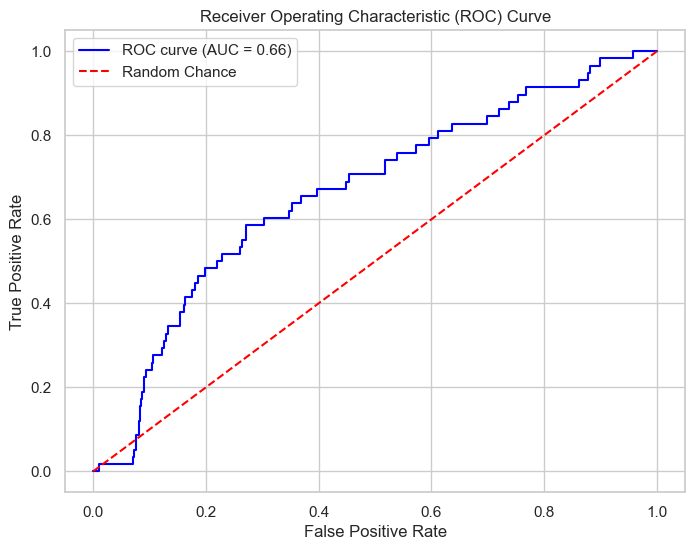


Model evaluation complete.


In [9]:
# --- 6. Model Evaluation ---
print("\n6. Evaluating Model Performance...")

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {auc_score:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

print("\nModel evaluation complete.")

In [10]:
# --- 7. Identify High-Risk Orders ---
print("\n7. Identifying High-Risk Orders and Generating CSV...")


all_pred_proba = model.predict_proba(X)[:, 1] 
orders_df['PredictedReturnProbability'] = all_pred_proba

risk_threshold = 0.6 

high_risk_orders = orders_df[orders_df['PredictedReturnProbability'] >= risk_threshold].copy()


output_columns = ['Order ID', 'Order Date', 'Customer Name', 'Segment', 'Region',
                  'Category', 'Sub-Category', 'Product Name',
                  'Sales', 'Quantity', 'Discount', 'Profit',
                  'IsReturned', 'PredictedReturnProbability']


high_risk_orders_output = high_risk_orders[output_columns].sort_values(by='PredictedReturnProbability', ascending=False) 

output_filename = 'high_risk_orders.csv'
try:
    high_risk_orders_output.to_csv(output_filename, index=False)
    print(f"\nSuccessfully generated CSV file with {len(high_risk_orders_output)} high-risk orders: {output_filename}")
except Exception as e:
    print(f"\nError saving CSV file: {e}")

print("\n--- Section 7 Complete ---")


output_filename = 'high_risk_orders.csv'
try:
    high_risk_orders_output.to_csv(output_filename, index=False)
    print(f"\nSuccessfully generated CSV file with {len(high_risk_orders_output)} high-risk orders: {output_filename}")
except Exception as e:
    print(f"\nError saving CSV file: {e}")



7. Identifying High-Risk Orders and Generating CSV...

Successfully generated CSV file with 541 high-risk orders: high_risk_orders.csv

--- Section 7 Complete ---

Successfully generated CSV file with 541 high-risk orders: high_risk_orders.csv
